In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import copy
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

root_dir = "/content/drive/My Drive/"
project_folder = "Thesis/"
os.chdir(root_dir+project_folder)
!pwd

plt.ion()  

import warnings
warnings.filterwarnings('ignore')

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if use_gpu:
    print("Using CUDA")
else:
  print("Not Using CUDA")

/content/drive/.shortcut-targets-by-id/1A9E7aUBTfenyLMSzN35zl5kPcloJjwz5/Thesis
Using CUDA


In [ ]:
data_dir = root_dir+project_folder+'dataset_spilited'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_dataset = datasets.ImageFolder(
        os.path.join(data_dir, 'train'), 
        transform=data_transform
    )
train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=8,
        shuffle=True, num_workers=2
    )

val_dataset = datasets.ImageFolder(
        os.path.join(data_dir, 'val'), 
        transform=data_transform
    )
val_dataloader = torch.utils.data.DataLoader(
        val_dataset, batch_size=8,
        shuffle=True, num_workers=2
    )

test_dataset = datasets.ImageFolder(
        os.path.join(data_dir, 'test'), 
        transform=data_transform
    )
test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=8,
        shuffle=True, num_workers=2
    )

print("Loaded {} images under train".format(len(train_dataset)))
print("Loaded {} images under val".format(len(val_dataset)))
print("Loaded {} images under test".format(len(test_dataset)))
    
class_names = train_dataset.classes
print("Classes:", class_names)

Loaded 182 images under train
Loaded 29 images under val
Loaded 95 images under test
Classes: ['Canker', 'Dot', 'Mummification', 'Rust']


In [ ]:
def convertToImage(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

def imageDisplay(images, labels, row=None, col=None):
    if row and col:
      fig, axis = plt.subplots(row, col, figsize=(15, 10))
    else:
      fig, axis = plt.subplots(1, len(images), figsize=(10, 10))
      
    for i, ax in enumerate(axis.flat):
      with torch.no_grad():
          image, label = images[i], labels[i]
          ax.axis('off')
          ax.imshow(convertToImage(image)) # add image
          ax.set_title(f"{class_names[label.item()]}", fontsize=14) # add label

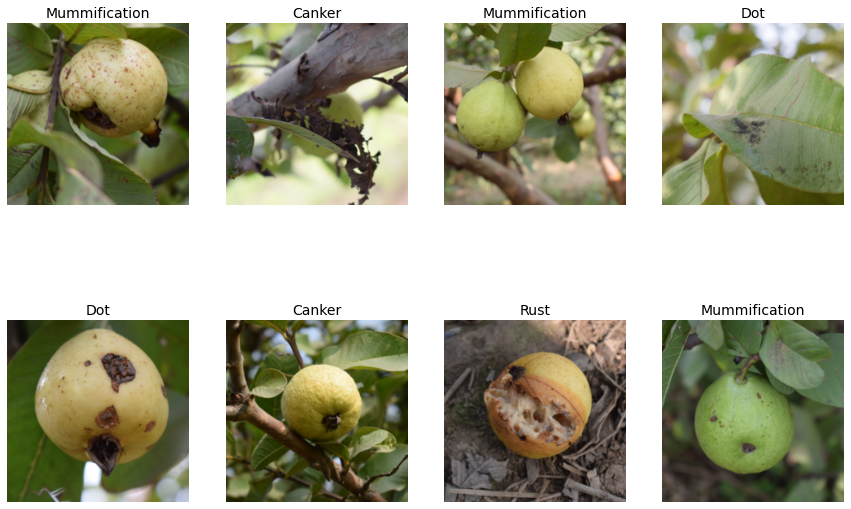

In [ ]:
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
imageDisplay(images, labels, 2, 4)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 16 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64,kernel_size=3,stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*4*4,512 )
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)   

    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout(self.batchnorm2(self.pool(x)))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(self.conv4(x))
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim = 1)
        return x

In [ ]:
from torchsummary import summary

model = Net() # On CPU
model = Net().to(device)  # On GPU
print(model)
summary(model, (3, 224, 224))

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.4, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)
----------------------------------------------------------------
        Layer (typ

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
n_epochs = 12
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    model.train()
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 5 == 0:
            print ('Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\nmean train loss: {np.mean(train_loss):.4f}, train loss: {running_loss/total_step}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (val_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(val_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'mean validation loss: {np.mean(val_loss):.4f}, validation loss: {batch_loss/len(val_dataloader)}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'model_classification_tutorial.pt')
            print('Detected network improvement, saving current model\n')
    model.train()

Epoch 1

Epoch [1/12], Batch [0/23], Loss: 0.5958
Epoch [1/12], Batch [5/23], Loss: 0.6269
Epoch [1/12], Batch [10/23], Loss: 0.6704
Epoch [1/12], Batch [15/23], Loss: 0.5268
Epoch [1/12], Batch [20/23], Loss: 0.6770

mean train loss: 0.6021, train loss: 0.6020719979120337, train acc: 83.5165
mean validation loss: 1.5660, validation loss: 1.5659828186035156, validation acc: 31.0345

Detected network improvement, saving current model

Epoch 2

Epoch [2/12], Batch [0/23], Loss: 0.4863
Epoch [2/12], Batch [5/23], Loss: 0.5541
Epoch [2/12], Batch [10/23], Loss: 0.6491
Epoch [2/12], Batch [15/23], Loss: 0.8598
Epoch [2/12], Batch [20/23], Loss: 0.4704

mean train loss: 0.6123, train loss: 0.6226136606672535, train acc: 78.5714
mean validation loss: 1.5305, validation loss: 1.4950226247310638, validation acc: 27.5862

Detected network improvement, saving current model

Epoch 3

Epoch [3/12], Batch [0/23], Loss: 0.7468
Epoch [3/12], Batch [5/23], Loss: 0.2717
Epoch [3/12], Batch [10/23], Loss

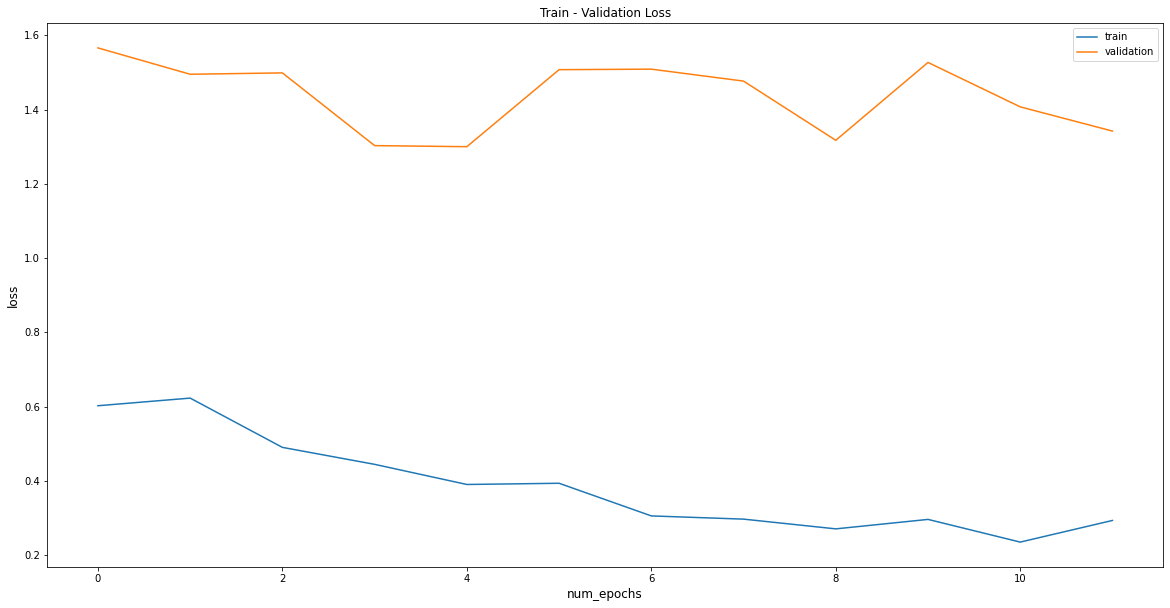

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

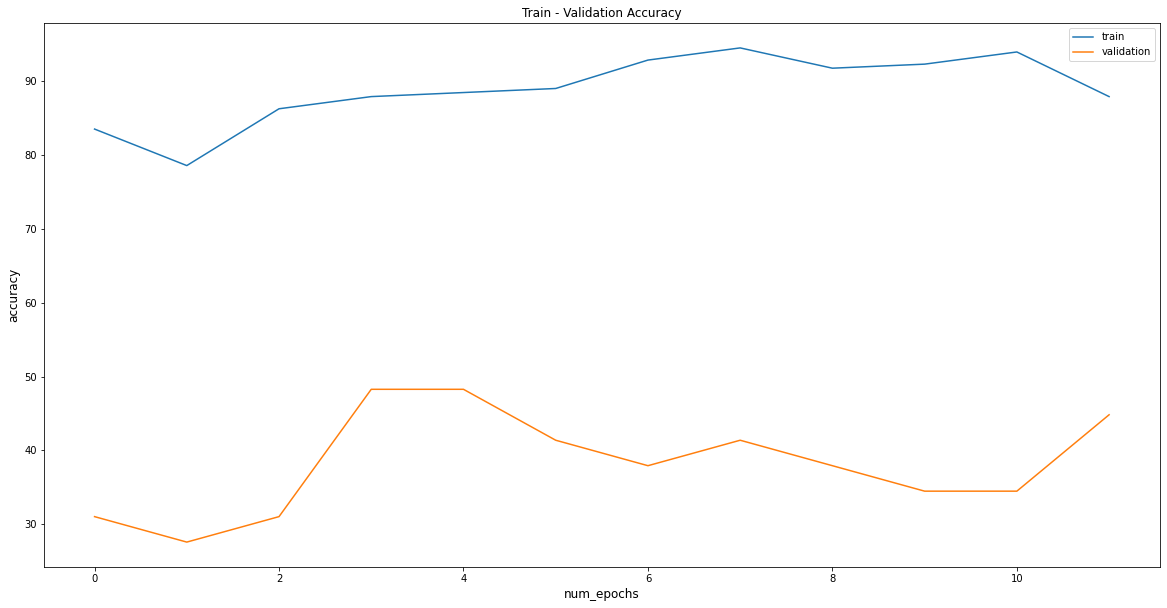

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

Batch Train  accurate: 6/8
Batch Train  accurate: 4/8
Batch Train  accurate: 5/8
Batch Train  accurate: 7/8
Batch Train  accurate: 6/8
Batch Train  accurate: 7/8
Batch Train  accurate: 6/8
Batch Train  accurate: 5/8
Batch Train  accurate: 7/8
Batch Train  accurate: 6/8
Batch Train  accurate: 6/8
Batch Train  accurate: 5/8
Batch Train  accurate: 6/8
Batch Train  accurate: 5/8
Batch Train  accurate: 6/8
Batch Train  accurate: 5/8
Batch Train  accurate: 6/8
Batch Train  accurate: 6/8
Batch Train  accurate: 4/8
Batch Train  accurate: 5/8
Batch Train  accurate: 3/8
Batch Train  accurate: 6/8
Batch Train  accurate: 5/6
Train accurate: 127/182

Train acc: 69.7802

               precision    recall  f1-score   support

       Canker       0.84      0.80      0.82        46
          Dot       0.97      0.71      0.82        45
Mummification       0.51      1.00      0.68        49
         Rust       1.00      0.21      0.35        42

     accuracy                           0.70       182
  

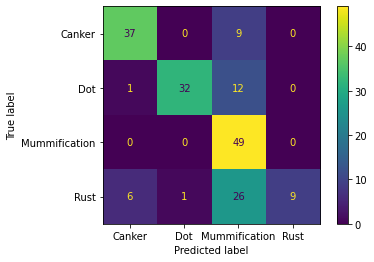

In [ ]:
#Evaluating train dataset
total=0
correct=0
predictions = []
true_labels = []
with torch.no_grad():
    model.eval()
    for data, target in (train_dataloader):
        data, target = data.to(device), target.to(device)# on GPU
        outputs = model(data)
        _,pred = torch.max(outputs, dim=1)
        true_labels=true_labels+target.squeeze().tolist()
        predictions=predictions+pred.squeeze().tolist()
        correct += torch.sum(pred==target).item()
        total += target.size(0)
        print(f'Batch Train  accurate: {torch.sum(pred==target).item()}/{target.size(0)}')
    print(f'Train accurate: {correct}/{total}\n')
    print(f'Train acc: {(100 * correct / total):.4f}\n')

print(classification_report(true_labels, predictions, target_names=class_names))
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()

Batch Validation accurate: 4/8
Batch Validation accurate: 3/8
Batch Validation accurate: 4/8
Batch Validation accurate: 2/5
Validation accurate: 13/29

Validation acc: 44.8276

               precision    recall  f1-score   support

       Canker       0.57      0.57      0.57         7
          Dot       0.50      0.14      0.22         7
Mummification       0.40      1.00      0.57         8
         Rust       0.00      0.00      0.00         7

     accuracy                           0.45        29
    macro avg       0.37      0.43      0.34        29
 weighted avg       0.37      0.45      0.35        29



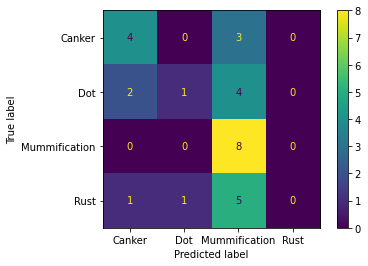

In [ ]:
#Evaluating validation dataset
total=0
correct=0
predictions = []
true_labels = []
with torch.no_grad():
    model.eval()
    for data, target in (val_dataloader):
        data, target = data.to(device), target.to(device)# on GPU
        outputs = model(data)
        _,pred = torch.max(outputs, dim=1)
        true_labels=true_labels+target.squeeze().tolist()
        predictions=predictions+pred.squeeze().tolist()
        correct += torch.sum(pred==target).item()
        total += target.size(0)
        print(f'Batch Validation accurate: {torch.sum(pred==target).item()}/{target.size(0)}')
    print(f'Validation accurate: {correct}/{total}\n')
    print(f'Validation acc: {(100 * correct / total):.4f}\n')

print(classification_report(true_labels, predictions, target_names=class_names))
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()

Batch Test accurate: 2/8
Batch Test accurate: 2/8
Batch Test accurate: 2/8
Batch Test accurate: 2/8
Batch Test accurate: 4/8
Batch Test accurate: 3/8
Batch Test accurate: 4/8
Batch Test accurate: 2/8
Batch Test accurate: 3/8
Batch Test accurate: 3/8
Batch Test accurate: 2/8
Batch Test accurate: 3/7
Test accurate: 32/95

Test acc: 33.6842

               precision    recall  f1-score   support

       Canker       0.40      0.25      0.31        24
          Dot       0.57      0.17      0.26        24
Mummification       0.30      0.85      0.44        26
         Rust       0.00      0.00      0.00        21

     accuracy                           0.34        95
    macro avg       0.32      0.32      0.25        95
 weighted avg       0.33      0.34      0.26        95



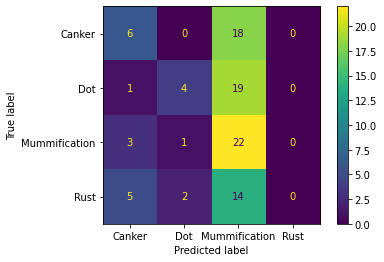

In [ ]:
#Evaluating test dataset
total=0
correct=0
predictions = []
true_labels = []
with torch.no_grad():
    model.eval()
    for data, target in (test_dataloader):
        data, target = data.to(device), target.to(device)# on GPU
        outputs = model(data)
        _,pred = torch.max(outputs, dim=1)
        true_labels=true_labels+target.squeeze().tolist()
        predictions=predictions+pred.squeeze().tolist()
        correct += torch.sum(pred==target).item()
        total += target.size(0)
        print(f'Batch Test accurate: {torch.sum(pred==target).item()}/{target.size(0)}')
    print(f'Test accurate: {correct}/{total}\n')
    print(f'Test acc: {(100 * correct / total):.4f}\n')

print(classification_report(true_labels, predictions, target_names=class_names))
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()

In [ ]:
def displayPrediction(dataiter):
  images, labels = dataiter.next()
  # Viewing data examples used for training
  fig, axis = plt.subplots(2, 4, figsize=(15, 10))
  with torch.no_grad():
      model.eval()
      for ax, image, label in zip(axis.flat, images, labels):
          ax.axis('off')
          ax.imshow(convertToImage(image)) # add image
          image_tensor = image.unsqueeze_(0)
          image_tensor = image_tensor.to(device) # on GPU
          output_ = model(image_tensor)
          output_ = output_.argmax()
          k = output_.item()==label.item()
          ax.set_title(str(class_names[label.item()])+"-"+str(class_names[output_.item()])+":" +str(k)) # add label

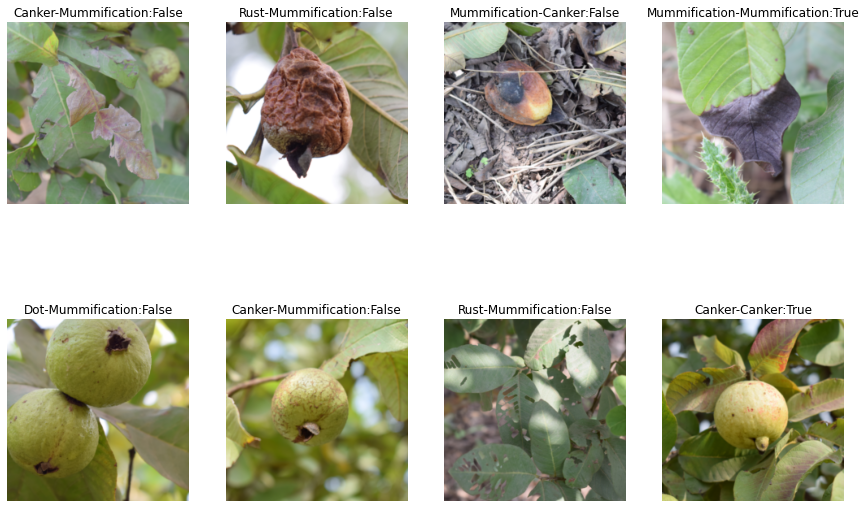

In [ ]:
dataiter = iter(test_dataloader)
displayPrediction(dataiter)

In [ ]:
def displaySingleImagePrediction(link):
    image = Image.open(link)
    plt.imshow(image)
    image=data_transform(image).float()
    image.unsqueeze(0)
    image=image.unsqueeze(0)
    image_tensor = image.to(device) # on GPU
    output_ = model(image_tensor)
    output_ = output_.argmax()
    plt.title(str(class_names[output_.item()])) # add label
    plt.axis('off')
    plt.show()

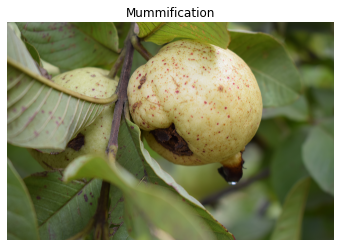

In [ ]:
link = "/content/drive/My Drive/Thesis/Copy of DSC_0236.JPG"
displaySingleImagePrediction(link)